# Global birth rate analysis

Birth rate by country and the global birth rate will be analyzed under the impacts of the following factors: 
- Financial: GDP per Capita
- Social: Happiness index, Social support score, life expectancy, freedom to make life choices, generosity,perception of corruption
- Jobs: Unemployment rate

In [430]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson

## Data Import & Data Preparation

In [431]:
# Data import
df_birth_rate = pd.read_csv("birth_rate.csv")
df_gdp = pd.read_csv("GDP.csv")
df_happiness_index = pd.read_excel("DataForFigure2.1WHR2023.xls")
df_unemployment_rate = pd.read_csv('unemployment_rate.csv')
df_inflation_rate = pd.read_excel('inflation-data.xlsx',sheet_name='hcpi_a')


In [432]:
# Drop duplicates & rename columns
df_birth_rate = df_birth_rate.rename({'country': 'Country'}, axis='columns')
df_gdp = df_gdp.drop_duplicates(subset='country', keep='first')
df_gdp = df_gdp.rename({'country': 'Country'}, axis='columns')
df_happiness_index = df_happiness_index.rename({'Country name': 'Country'},
                                               axis='columns')
df_unemployment_rate = df_unemployment_rate.rename({'country': 'Country'},
                                                    axis='columns')
df_inflation_rate = df_inflation_rate.rename({2022:'inflation'}, axis='columns')


In [433]:
# Preliminary variable selection
df_birth_rate = df_birth_rate[['birthRate', 'Country']]
df_gdp = df_gdp[['Country', 'gdpPerCapita']]
df_happiness_index = df_happiness_index[['Country', 'Ladder score', 'Social support', 
                                         'Healthy life expectancy',
                                         'Freedom to make life choices', 
                                         'Generosity', 'Perceptions of corruption']]
df_unemployment_rate = df_unemployment_rate[['Country', 'rateWb']]
df_inflation_rate = df_inflation_rate[['Country', 'inflation']]


In [434]:
# Main data frame preparation
df_final = df_birth_rate.merge(df_gdp,
                                on='Country').merge(df_happiness_index,
                                                     on='Country').merge(df_unemployment_rate, on='Country').merge(df_inflation_rate, on='Country')

df_final.columns

Index(['birthRate', 'Country', 'gdpPerCapita', 'Ladder score',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'rateWb', 'inflation'],
      dtype='object')

In [435]:
df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']] = df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]*100
df_final.loc[8, 'inflation'] = 3.9

In [436]:
# Data partition
df_predictors = df_final[['gdpPerCapita', 'Ladder score', 'Social support', 
                          'Healthy life expectancy', 'Freedom to make life choices',
                          'Generosity', 'Perceptions of corruption', 'rateWb',
                            'inflation']]
df_target = df_final['birthRate']

x_train, x_test, y_train, y_test = train_test_split(df_predictors,df_target,test_size=0.25)


## Model Fit & Model result

In [437]:
model = linear_model.LinearRegression()

In [438]:
model.fit(x_train,y_train)

LinearRegression()

In [439]:
# birth_rate fitted and birth_rate prediction
y_fitted = model.predict(x_train)
y_predict = model.predict(x_test)

In [440]:
# residuals from train & test
residuals_train = y_train - y_fitted
residuals_test = y_test - y_predict

In [441]:
# Coefficients
coef_gdp = model.coef_[0]
coef_happiness_index = model.coef_[1]
coef_social_support = model.coef_[2]
coef_life_expectancy = model.coef_[3]
coef_freedom = model.coef_[4]
coef_generosity = model.coef_[5]
coef_corruption = model.coef_[6]
coef_unemployment = model.coef_[7]
coef_inflation = model.coef_[8]
intercept = model.intercept_
model.coef_

array([-1.11990246e-07,  3.26399484e-01, -1.32998780e-01, -1.31869959e+00,
       -7.59727018e-02,  6.72322161e-04, -6.88676391e-02, -1.42689083e-01,
       -1.04456067e-02])

In [442]:
print('model = %f + %f GDP %f Happiness index  %f Social support %f life expectancy  %f freedom  %f generosity  %f corruption  %f Unemployment %f Inflation' % (intercept, coef_gdp, coef_happiness_index, coef_social_support, coef_life_expectancy, coef_freedom, coef_generosity, coef_corruption, coef_unemployment, coef_inflation))

model = 125.621676 + -0.000000 GDP 0.326399 Happiness index  -0.132999 Social support -1.318700 life expectancy  -0.075973 freedom  0.000672 generosity  -0.068868 corruption  -0.142689 Unemployment -0.010446 Inflation


In [443]:
stats_model = sm.OLS(y_train, x_train).fit()

## Model & Predictors Evaluation

In [470]:
def model_significance(y_train_set, y_pred, p):
    y_mean = np.mean(y_train_set)
    tss = ((y_train_set - y_mean)**2).sum()
    rss = ((y_train_set - y_pred)**2).sum()
    n = len(y_train_set)
    f_test = (tss-rss)/(rss/(n-p-1))
    print(f_test)
    if f_test > 1:
        print("Reject Ho. At least one of the model coefficients is significant.")
    if f_test <=1: 
        print("Accept Ho. No coefficients are useful.")


def coefficient_testing(coeff, residuals, trainset,p):
    """Perform Hypothesis testing to determine if Coefficient in regression is significant"""
    # Obtain the residual standard deviation
    residual_variance = np.var(residuals)
    x_mean = np.mean(trainset)
    x_squared = ((trainset - x_mean)**2).sum()
    coeff_var = residual_variance/ x_squared
    coeff_std = np.sqrt(coeff_var)
    print("coeff_var, std:",coeff_var, coeff_std)
    # Obtain t test
    print("Hypothesis: Ho: B1 = 0, Ha: B1 !=0")
    t_value = coeff/coeff_std
    print("t_value:", t_value)
    degree_of_freedom = len(trainset) - p -1
    p_value = stats.t.sf(abs(t_value), degree_of_freedom)*2
    print ("p_value: %.24f" % p_value)
    # Conclusion:
    if p_value < 0.05:
        print('Reject Ho. The coefficient is significant, and has a relationship with the respond variable')
    if p_value > 0.05: 
        print('Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable')
    return None


def residual_zero_mean(residuals,p):
    n = len(residuals)
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    t_test = (residual_mean)/(residual_std/np.sqrt(n))
    p_value = stats.t.sf(t_test, n - p - 1)
    if p_value > 0.05:
        print("As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.")
    elif p_value <= 0.05: 
        print("As p_value is smaller than 0.95, there is sufficient evidence to reject Ho. Thus zero mean assumption is not appropriate.")

def tss_rss(y_train, y_pred):
    y_mean = np.mean(y_train)
    tss = ((y_train - y_mean)**2).sum()
    rss = ((y_train - y_pred)**2).sum()
    n = len(y_train)
    return tss, rss

def autocorrelation(residuals):
    print("Ho: There is no correlation among residuals")
    print("Ha: There is correlation between residuals")
    test = durbin_watson(residuals)
    print(test)
    if test>= 0 and test <= 1.5: 
        print("Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.")
    elif test > 1.5 and test <= 2.5:
        print("Do not reject Ho. There is no correlation among residuals.")
    elif test > 2.5:
        print("Reject Ho. There is sufficient evidence indicating a negative correlation in the residuals")
        
def normal_distribution(residuals):
    print("Ho: The residuals are normally distributed.")
    print("Ha: The residuals are not normally distributed.")
    k, p_value = stats.normaltest(residuals)
    print(p_value)
    if p_value < 0.05:
        print("Reject Ho. The residuals are not normally distributed.")
    elif p_value > 0.05:
        print("Do not have sufficient evidence to reject Ho. The residuals are normally distributed.")

### Model Evaluation

In [445]:
# Model evaluation - F test
model_significance(y_train, y_fitted, 8)

294.04753865809056
Reject Ho. At least one of the model coefficients is significant.


### Coefficient evaluation


In [446]:
# GDP coefficient
coefficient_testing(coef_gdp, residuals_train, x_train['gdpPerCapita'],8)

coeff_var, std: 4.861391921335594e-14 2.204856440073955e-07
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.5079253416388612
p_value: 0.612776497573339629099110
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [447]:
# Happiness index
coefficient_testing(coef_happiness_index, residuals_train, x_train['Ladder score'], 8)

coeff_var, std: 0.16680460080512557 0.4084171896543112
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.7991815521807322
p_value: 0.426336971500504313681290
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [448]:
# Social support
coefficient_testing(coef_social_support, residuals_train, x_train['Social support'],8)

coeff_var, std: 0.0012880082590004712 0.03588883195369377
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -3.7058542310830895
p_value: 0.000367578046188066849716
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [449]:
# Healthy life expectancy
coefficient_testing(coef_life_expectancy, residuals_train, x_train['Healthy life expectancy'], 8)

coeff_var, std: 0.0074434207536570466 0.08627526153919816
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -15.284793866775146
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [450]:
# Freedom to make life choices
coefficient_testing(coef_freedom, residuals_train, x_train['Freedom to make life choices'], 8)


coeff_var, std: 0.0018290345690724196 0.04276721371649572
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -1.776423927985949
p_value: 0.079119146986904975715760
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [451]:
# Generosity
coefficient_testing(coef_generosity, residuals_train, x_train['Generosity'], 8)

coeff_var, std: 0.0011016659028407995 0.03319135283233872
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.020255943314174785
p_value: 0.983885058454414540562993
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [452]:
# Perceptions of corruption
coefficient_testing(coef_corruption, residuals_train, x_train['Perceptions of corruption'], 8)

coeff_var, std: 0.0008218958460063251 0.028668725922271557
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.402186942507012
p_value: 0.018399662383815695160250
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [453]:
# Unemployment rate: rateWb
coefficient_testing(coef_unemployment, residuals_train, x_train['rateWb'], 8)

coeff_var, std: 0.007443528526169679 0.08627588612219338
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -1.6538698002962502
p_value: 0.101716983890146647762087
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [454]:
# Inflation rate
coefficient_testing(coef_inflation, residuals_train, x_train['inflation'],8)

coeff_var, std: 0.0001528094554187949 0.012361612169081949
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.8450035923922993
p_value: 0.400400408352232783926183
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


## Accuracy Evaluation

#### Train set

In [455]:
tss_train, rss_train = tss_rss(y_train, y_fitted)

In [456]:
n_train = len(y_train)
rse_train = np.sqrt(rss_train/(n_train-8-1))
r_squared_train = (tss_train-rss_train)/tss_train

In [457]:
print("RSE:", rse_train)
print("R-squared:", r_squared_train)

RSE: 4.979519888448681
R-squared: 0.7696621726471723


#### Test set

In [458]:
tss_test, rss_test = tss_rss(y_test, y_predict)
n_test = len(y_test)
rse_test = np.sqrt(rss_test/(n_test - 8-1))
r_squared_test = (tss_test-rss_test)/tss_test

In [459]:
print("RSE:", rse_test)
print("R-squared:", r_squared_test)

RSE: 5.008244176935813
R-squared: 0.8295082774298256


## Residuals Evaluation

Residuals will be assessed for the following factors: 
- Mean of zero
- Normally distributed
- Constant variance
- Autocorrelation check

In [460]:
# Test residuals mean of zero
residual_zero_mean(residuals_test, 8)

As p_value is smaller than 0.95, there is sufficient evidence to reject Ho. Thus zero mean assumption is not appropriate.


Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.5486060075278344
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.


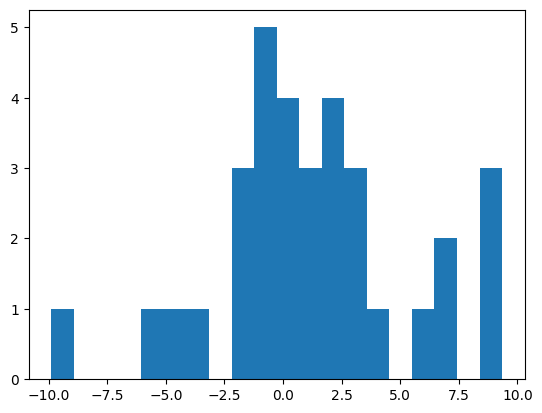

In [471]:
# Test for Normal distribution
plt.hist(residuals_test, bins=20)

normal_distribution(residuals_test)

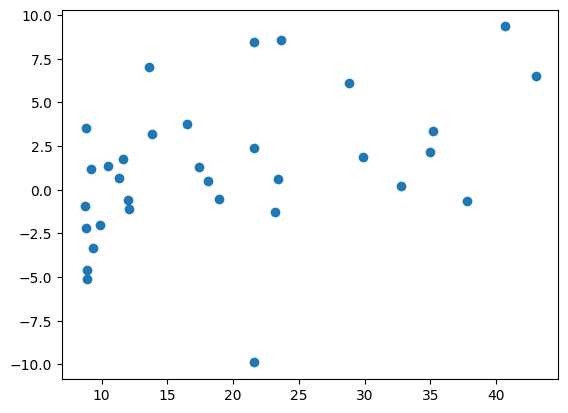

In [462]:
# Test for constant variance
plt.scatter(y_test, residuals_test)

In [464]:
# Autocorrelation check
autocorrelation(residuals_test)



Ho: There is no correlation among residuals
Ha: There is correlation between residuals
1.770929396922798
Do not reject Ho. There is no correlation among residuals.
